# General Section:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset path and parameters
dataset_path = "/content/drive/MyDrive/CLDD_Dataset/Original Dataset"
img_height, img_width = 224, 224
batch_size = 32
class_names = ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
               'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
train_data, val_data = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Classes found:", os.listdir(dataset_path))
print(f"Class names: {train_data.class_names}")

Found 2137 files belonging to 7 classes.
Using 1710 files for training.
Using 427 files for validation.
Classes found: ['Leaf Hopper Jassids', 'Curl Virus', 'Healthy Leaf', 'Leaf Variegation', 'Bacterial Blight', 'Leaf Redding', 'Herbicide Growth Damage']
Class names: ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage', 'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']


In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        labels = tf.argmax(labels, axis=1).numpy()
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Function to show images
def show_images(dataset, max_row=2, max_col=5):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(min(max_row * max_col, len(images))):
            r, c = i // max_col, i % max_col
            ax = plt.subplot(max_row, max_col, i + 1)
            ax.imshow(images[i].numpy().astype('uint8'))
            ax.set_title(class_names[np.argmax(labels[i])])
            ax.axis('off')
    plt.show()

# Augmentation (Single):

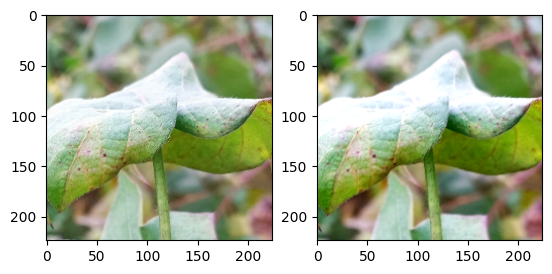

In [ ]:
# Augmentation pipeline
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# Visualize original and augmented images
_, axs = plt.subplots(1, 2)
for images, labels in train_data.take(1):
    axs[0].imshow(images[0].numpy().astype('uint8'))
    img = AUG(images[0], training=True)
    axs[1].imshow(img.numpy().astype('uint8'))
plt.show()

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            augmented_images.extend([image, aug_img])
            augmented_labels.extend([label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

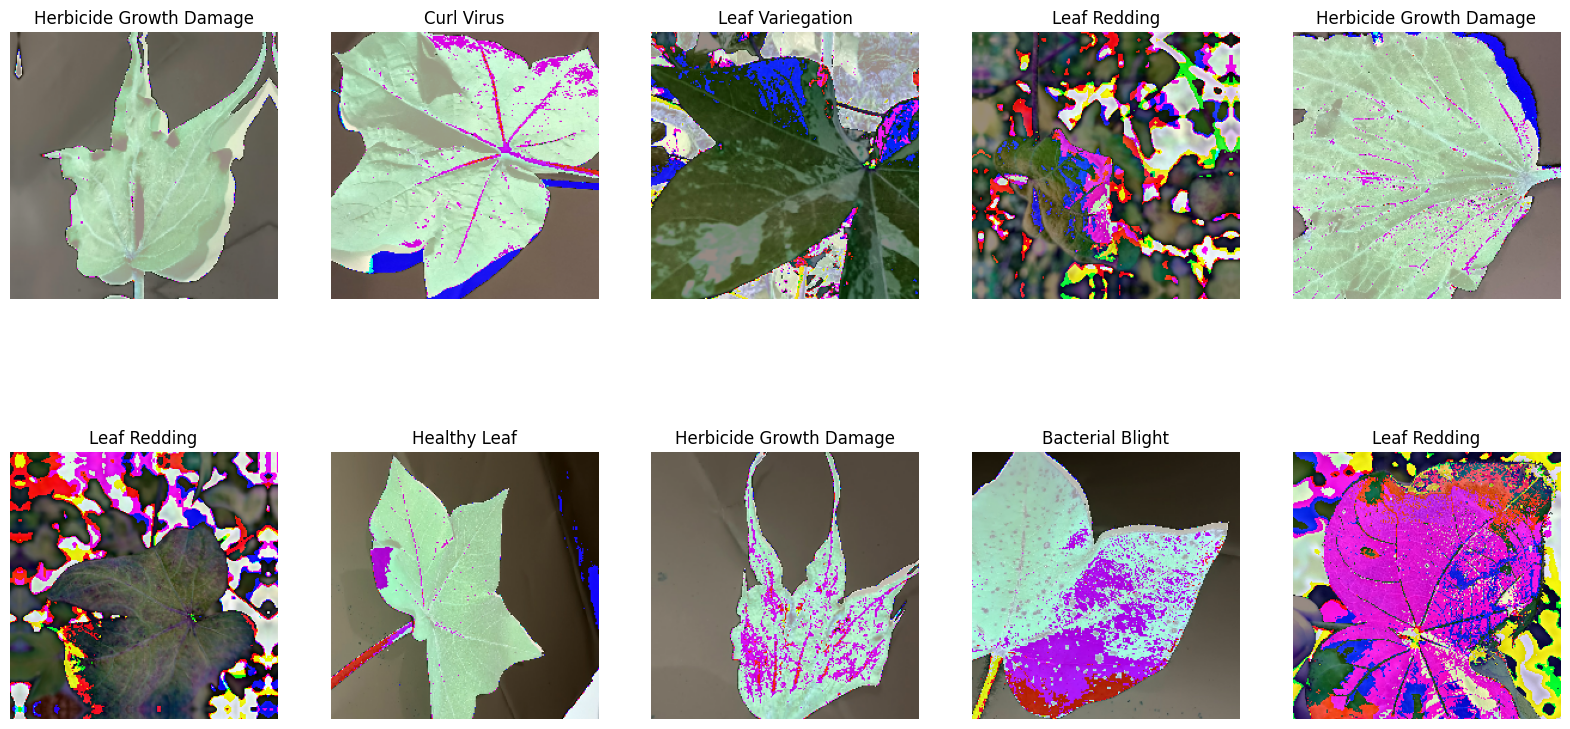

Original train data class counts: {'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208, 'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176, 'Leaf Redding': 458, 'Leaf Variegation': 87}
Augmented train data class counts: {'Bacterial Blight': 410, 'Curl Virus': 714, 'Healthy Leaf': 416, 'Herbicide Growth Damage': 438, 'Leaf Hopper Jassids': 352, 'Leaf Redding': 916, 'Leaf Variegation': 174}


In [ ]:
show_images(training_aug_data)

# Verify class distribution
print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
# Preprocess input for ResNet50
def preprocess_input(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Compute class weights for imbalance
class_counts = {
    'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208,
    'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176,
    'Leaf Redding': 458, 'Leaf Variegation': 87
}
labels = []
for name, count in class_counts.items():
    label_idx = class_names.index(name)
    labels.extend([label_idx] * count)
labels = tf.convert_to_tensor(labels)
class_weights = compute_class_weight('balanced', classes=tf.unique(labels)[0].numpy(), y=labels.numpy())
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1916376306620209), 1: np.float64(0.6842737094837935), 2: np.float64(1.1744505494505495), 3: np.float64(1.1154598825831703), 4: np.float64(1.3879870129870129), 5: np.float64(0.5333749220212103), 6: np.float64(2.8078817733990147)}


In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 120s 975ms/step - accuracy: 0.6673 - loss: 0.9989 - val_accuracy: 0.9415 - val_loss: 0.1872
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.9146 - loss: 0.2159 - val_accuracy: 0.9461 - val_loss: 0.1867
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.9540 - loss: 0.1240 - val_accuracy: 0.9602 - val_loss: 0.1585
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9572 - loss: 0.1053 - val_accuracy: 0.9555 - val_loss: 0.1523
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.9659 - loss: 0.0780 - val_accuracy: 0.9578 - val_loss: 0.1253
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9738 - loss: 0.0653 - val_accuracy: 0.9508 - val_loss: 0.1847
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.9730 - loss: 0.0756 - val_accuracy: 0.9578 - val_loss: 0.1352
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9778 - loss: 

In [ ]:
# Stage 2: Fine-tune last 50 layers (exclude BatchNormalization)
for layer in base_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 50 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 50 layers...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 56s 337ms/step - accuracy: 0.9870 - loss: 0.0325 - val_accuracy: 0.9672 - val_loss: 0.1300
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.9918 - loss: 0.0210 - val_accuracy: 0.9649 - val_loss: 0.1222
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.9958 - loss: 0.0143 - val_accuracy: 0.9649 - val_loss: 0.1517
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.9956 - loss: 0.0111 - val_accuracy: 0.9602 - val_loss: 0.1629
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.9968 - loss: 0.0119 - val_accuracy: 0.9672 - val_loss: 0.1277
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - accuracy: 0.9973 - loss: 0.0063 - val_accuracy: 0.9696 - val_loss: 0.1358
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.9969 - loss: 0.0069 - val_accuracy: 0.9649 - val_loss: 0.1536
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.9480 - loss: 0.2527
Validation loss: 0.2064, Validation accuracy: 0.9578
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.83      1.00      0.91        45
             Curl Virus       0.99      0.95      0.97        74
           Healthy Leaf       0.96      0.98      0.97        49
Herbicide Growth Damage       1.00      1.00    

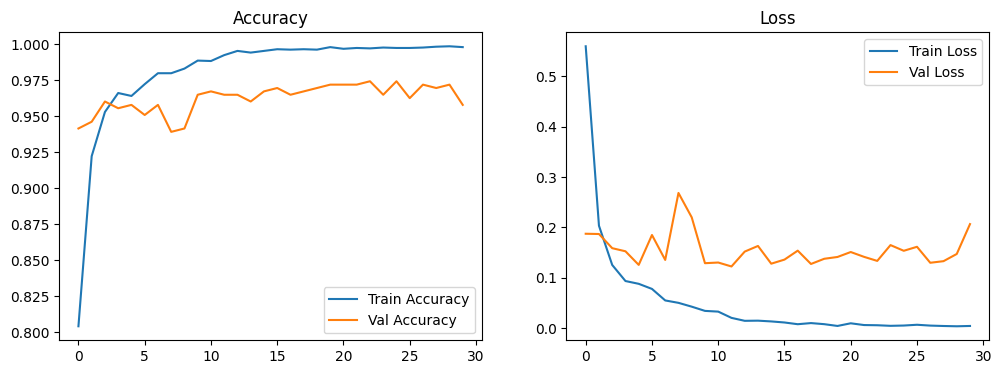

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

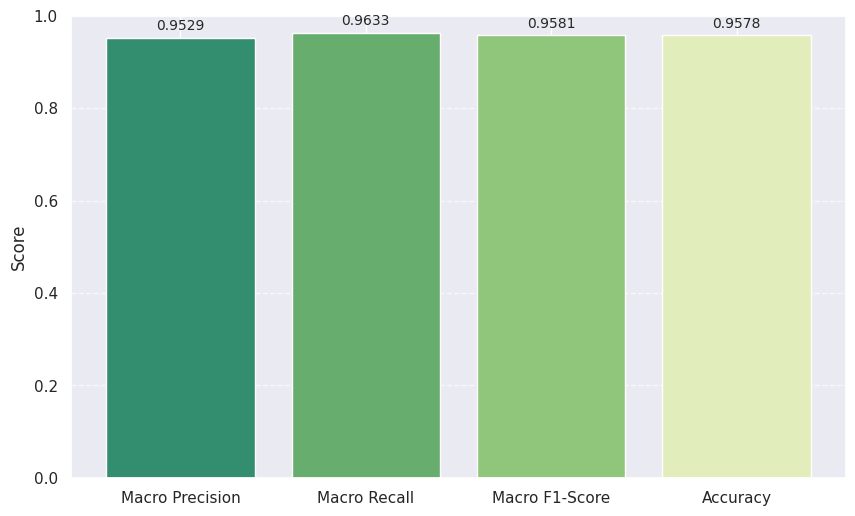

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  70,   1,   0,   3,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  3,   0,   0,   0,  45,   1,   0],
 [  6,   0,   0,   0,   2, 112,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandomZoom_RandomContrast] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('RN_FT50_D5_Acc9696.png')

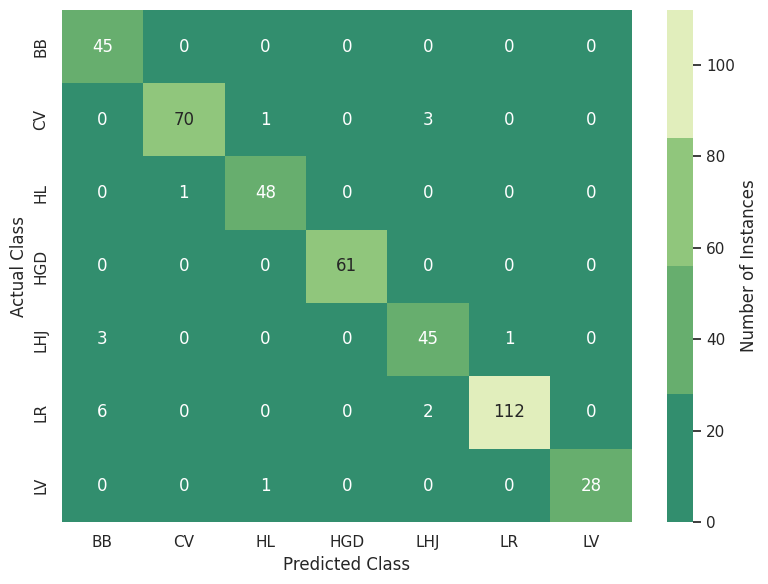

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  70,   1,   0,   3,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  3,   0,   0,   0,  45,   1,   0],
 [  6,   0,   0,   0,   2, 112,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

Fine tuning 40 Layers and Dropout 60%:

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.6262 - loss: 1.1397 - val_accuracy: 0.9251 - val_loss: 0.2610
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.8908 - loss: 0.3102 - val_accuracy: 0.9532 - val_loss: 0.1637
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.9377 - loss: 0.1805 - val_accuracy: 0.9555 - val_loss: 0.1473
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9543 - loss: 0.1283 - val_accuracy: 0.9555 - val_loss: 0.1446
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.9683 - loss: 0.0988 - val_accuracy: 0.9368 - val_loss: 0.2174
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.9444 - loss: 0.1157 - val_accuracy: 0.9578 - val_loss: 0.1292
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.9695 - loss: 0.0968 - val_accuracy: 0.9602 - val_loss: 0.1357
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.9724 - loss: 0

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - accuracy: 0.9851 - loss: 0.0407 - val_accuracy: 0.9625 - val_loss: 0.1198
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9945 - loss: 0.0203 - val_accuracy: 0.9696 - val_loss: 0.1128
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.9940 - loss: 0.0189 - val_accuracy: 0.9696 - val_loss: 0.1268
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9973 - loss: 0.0104 - val_accuracy: 0.9696 - val_loss: 0.1165
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.9988 - loss: 0.0060 - val_accuracy: 0.9578 - val_loss: 0.1579
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.9938 - loss: 0.0152 - val_accuracy: 0.9649 - val_loss: 0.1776
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9719 - val_loss: 0.1390
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 18s 164ms

In [ ]:
# Evaluate model

from sklearn.metrics import classification_report, confusion_matrix
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9585 - loss: 0.2386
Validation loss: 0.1780, Validation accuracy: 0.9672
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.87      1.00      0.93        45
             Curl Virus       0.99      0.99      0.99        74
           Healthy Leaf       0.96      0.98      0.97        49
Herbicide Growth Damage       1.00      1.0

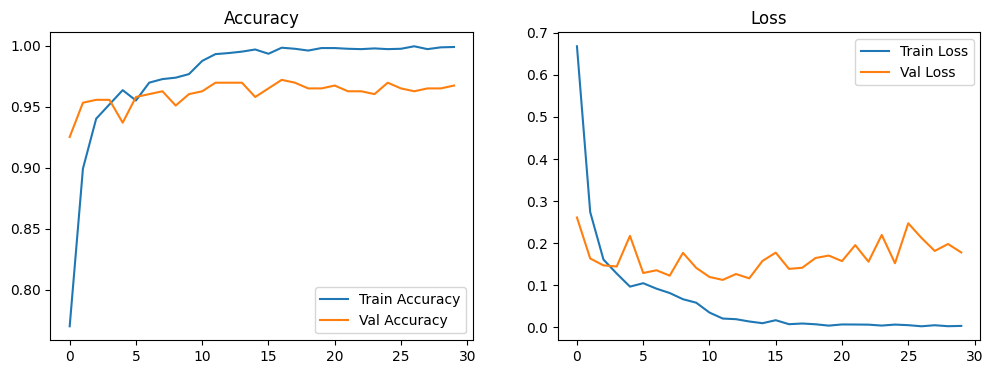

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

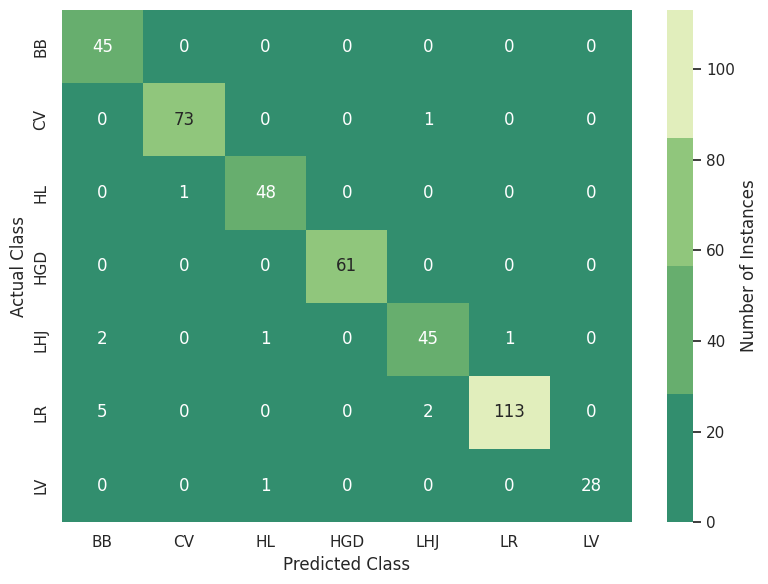

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  45,   1,   0],
 [  5,   0,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

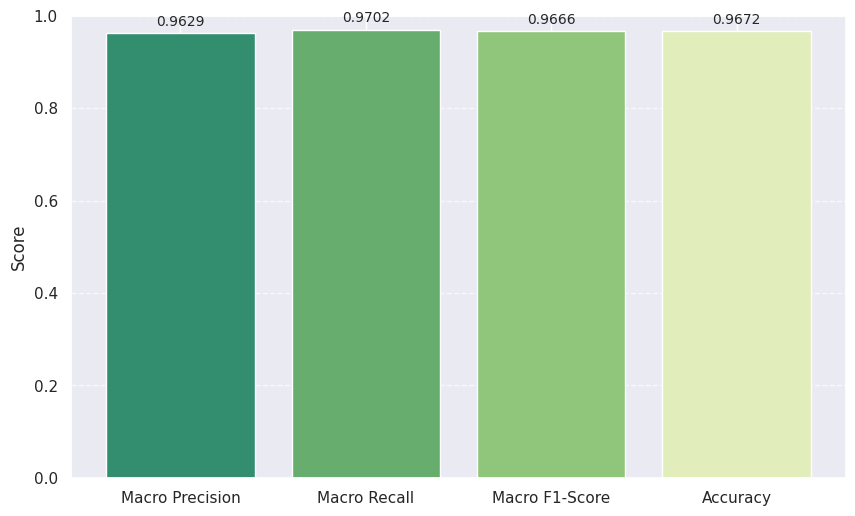

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  45,   1,   0],
 [  5,   0,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandomZoom_RandomContrast] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('RN_FT50_D5_Acc9696.png')

Fine Tuning Last 30 Layers:

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - accuracy: 0.6316 - loss: 1.1452 - val_accuracy: 0.9485 - val_loss: 0.1817
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - accuracy: 0.9129 - loss: 0.2457 - val_accuracy: 0.9415 - val_loss: 0.1798
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.9267 - loss: 0.1857 - val_accuracy: 0.9555 - val_loss: 0.1608
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.9412 - loss: 0.1394 - val_accuracy: 0.9578 - val_loss: 0.1526
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.9635 - loss: 0.0979 - val_accuracy: 0.9672 - val_loss: 0.1221
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9642 - loss: 0.0897 - val_accuracy: 0.9578 - val_loss: 0.1258
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9661 - loss: 0.0919 - val_accuracy: 0.9602 - val_loss: 0.1282
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9670 - loss: 0

In [ ]:
# Stage 2: Fine-tune last 30 layers (exclude BatchNormalization)
for layer in base_model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 30 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 30 layers...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 46s 287ms/step - accuracy: 0.9875 - loss: 0.0322 - val_accuracy: 0.9696 - val_loss: 0.1118
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.9903 - loss: 0.0289 - val_accuracy: 0.9625 - val_loss: 0.1375
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.9938 - loss: 0.0152 - val_accuracy: 0.9672 - val_loss: 0.1320
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 0.9578 - val_loss: 0.1579
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9973 - loss: 0.0099 - val_accuracy: 0.9649 - val_loss: 0.1448
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.9939 - loss: 0.0118 - val_accuracy: 0.9578 - val_loss: 0.1627
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9940 - loss: 0.0101 - val_accuracy: 0.9555 - val_loss: 0.2092
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms

In [ ]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix

val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9679 - loss: 0.1836
Validation loss: 0.1624, Validation accuracy: 0.9696
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.85      1.00      0.92        45
             Curl Virus       0.97      0.99      0.98        74
           Healthy Leaf       1.00      0.98      0.99        49
Herbicide Growth Damage       1.00      1.00    

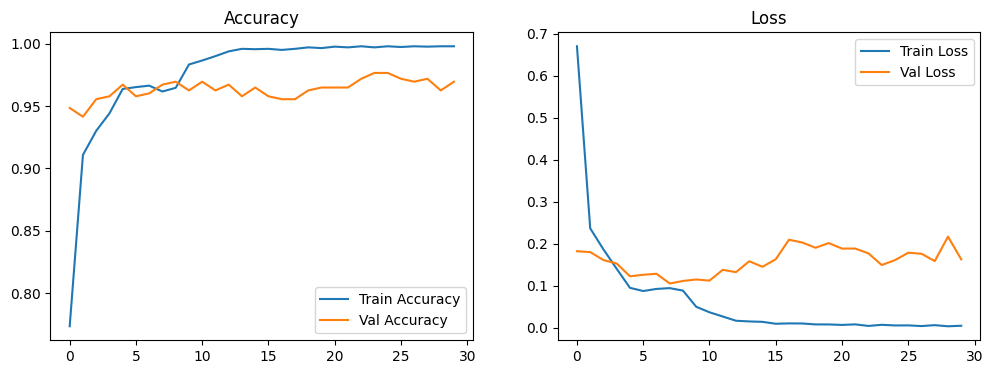

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

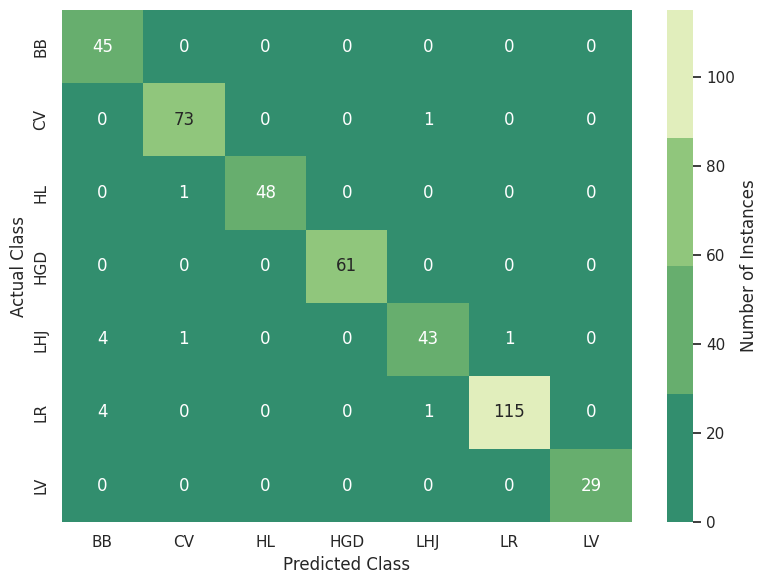

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  4,   1,   0,   0,  43,   1,   0],
 [  4,   0,   0,   0,   1, 115,   0],
 [  0,   0,   0,   0,   0,   0,  29]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

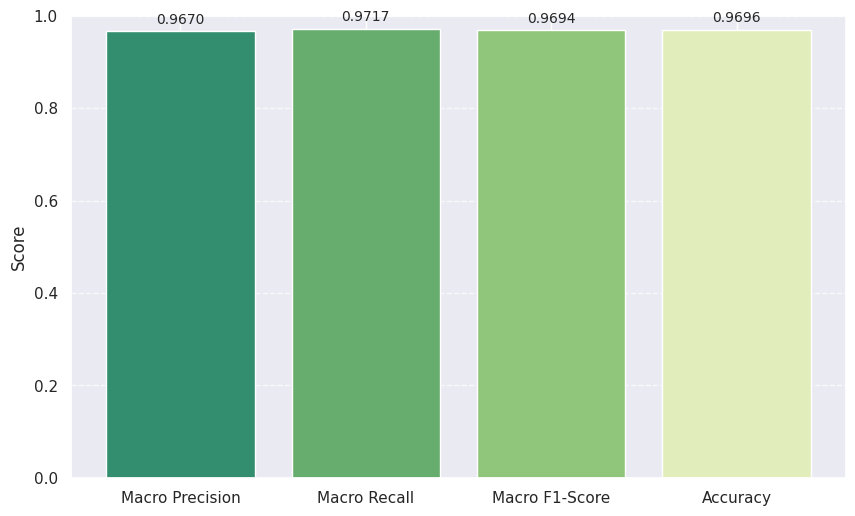

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  4,   1,   0,   0,  43,   1,   0],
 [  4,   0,   0,   0,   1, 115,   0],
 [  0,   0,   0,   0,   0,   0,  29]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandomZoom_RandomContrast] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('RN_FT50_D5_Acc9696.png')

# Augmentation (Double):

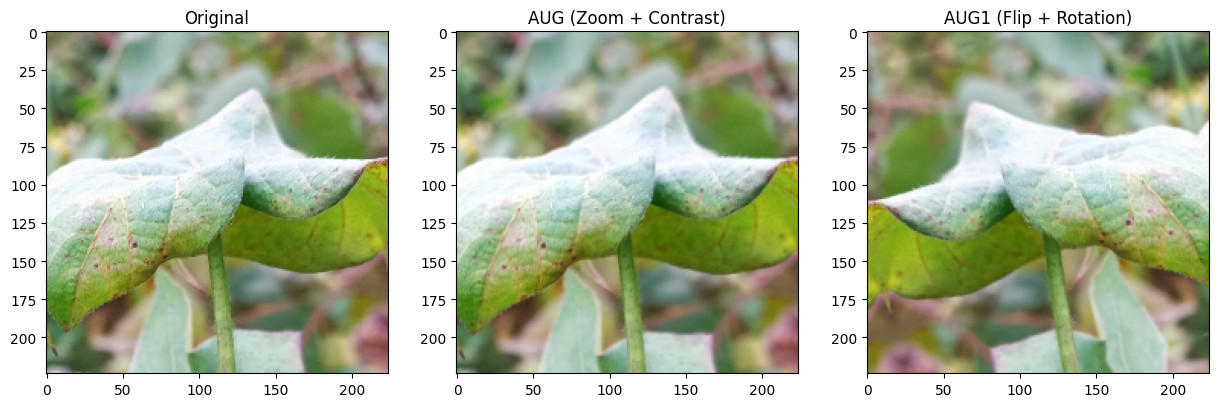

In [ ]:
# Augmentation pipelines
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

AUG1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Visualize original and augmented images
def visualize_augmentation(dataset):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for images, labels in dataset.take(1):
        img = images[0]
        axs[0].imshow(img.numpy().astype('uint8'))
        axs[0].set_title("Original")
        axs[1].imshow(AUG(img, training=True).numpy().astype('uint8'))
        axs[1].set_title("AUG (Zoom + Contrast)")
        axs[2].imshow(AUG1(img, training=True).numpy().astype('uint8'))
        axs[2].set_title("AUG1 (Flip + Rotation)")
        plt.show()

visualize_augmentation(train_data)

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            aug_img1 = AUG1(image, training=True)
            augmented_images.extend([image, aug_img, aug_img1])
            augmented_labels.extend([label, label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

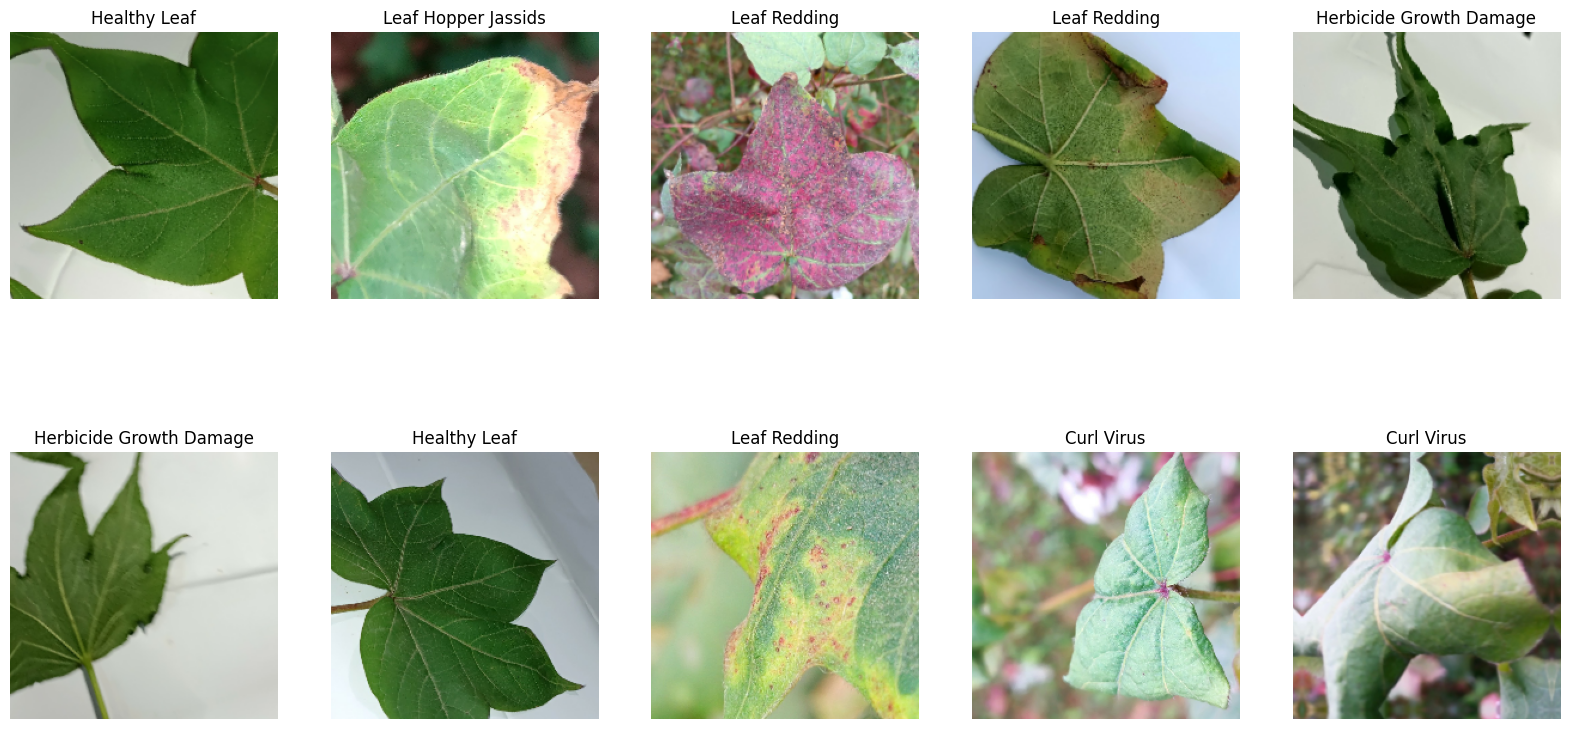

Original train data class counts: {'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208, 'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176, 'Leaf Redding': 458, 'Leaf Variegation': 87}
Augmented train data class counts: {'Bacterial Blight': 615, 'Curl Virus': 1071, 'Healthy Leaf': 624, 'Herbicide Growth Damage': 657, 'Leaf Hopper Jassids': 528, 'Leaf Redding': 1374, 'Leaf Variegation': 261}


In [ ]:
show_images(training_aug_data)

# Verify class distribution
print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
# Preprocess input for ResNet50
def preprocess_input(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Compute class weights for imbalance
class_counts = {
    'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208,
    'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176,
    'Leaf Redding': 458, 'Leaf Variegation': 87
}
labels = []
for name, count in class_counts.items():
    label_idx = class_names.index(name)
    labels.extend([label_idx] * count)
labels = tf.convert_to_tensor(labels)
class_weights = compute_class_weight('balanced', classes=tf.unique(labels)[0].numpy(), y=labels.numpy())
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1916376306620209), 1: np.float64(0.6842737094837935), 2: np.float64(1.1744505494505495), 3: np.float64(1.1154598825831703), 4: np.float64(1.3879870129870129), 5: np.float64(0.5333749220212103), 6: np.float64(2.8078817733990147)}


In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.6849 - loss: 0.9218 - val_accuracy: 0.9368 - val_loss: 0.2254
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9091 - loss: 0.2456 - val_accuracy: 0.9461 - val_loss: 0.1736
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9336 - loss: 0.1653 - val_accuracy: 0.9485 - val_loss: 0.1738
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.9496 - loss: 0.1272 - val_accuracy: 0.9578 - val_loss: 0.1407
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.9551 - loss: 0.1148 - val_accuracy: 0.9602 - val_loss: 0.1373
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9655 - loss: 0.0839 - val_accuracy: 0.9415 - val_loss: 0.1649
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.9668 - loss: 0.0862 - val_accuracy: 0.9578 - val_loss: 0.1419
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9641 - loss: 0.0

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 223ms/step - accuracy: 0.9846 - loss: 0.0496 - val_accuracy: 0.9532 - val_loss: 0.1674
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - accuracy: 0.9881 - loss: 0.0284 - val_accuracy: 0.9696 - val_loss: 0.1607
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9935 - loss: 0.0176 - val_accuracy: 0.9719 - val_loss: 0.1497
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.9904 - loss: 0.0230 - val_accuracy: 0.9696 - val_loss: 0.1517
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.9982 - loss: 0.0088 - val_accuracy: 0.9696 - val_loss: 0.1410
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9967 - loss: 0.0079 - val_accuracy: 0.9672 - val_loss: 0.1653
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9947 - loss: 0.0113 - val_accuracy: 0.9578 - val_loss: 0.2298
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 157ms

In [ ]:
# Evaluate model

from sklearn.metrics import classification_report, confusion_matrix
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.9512 - loss: 0.2216
Validation loss: 0.1640, Validation accuracy: 0.9625
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.95      0.89      0.92        45
             Curl Virus       0.97      0.99      0.98        74
           Healthy Leaf       0.96      0.98      0.97        49
Herbicide Growth Damage       1.00      1.00    

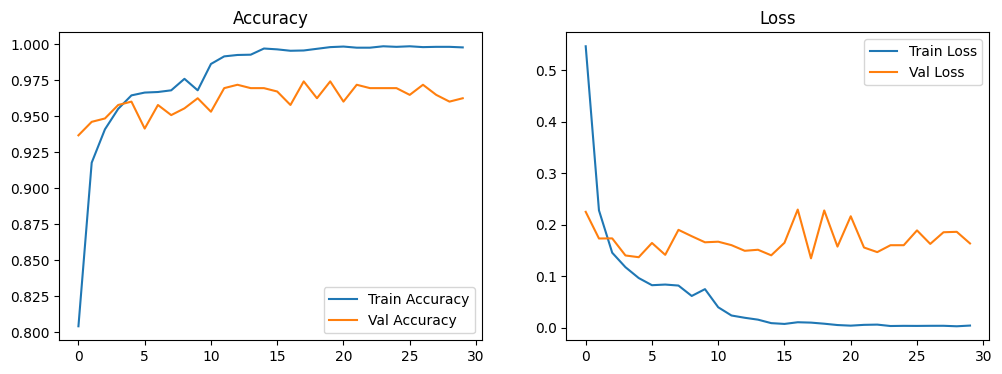

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

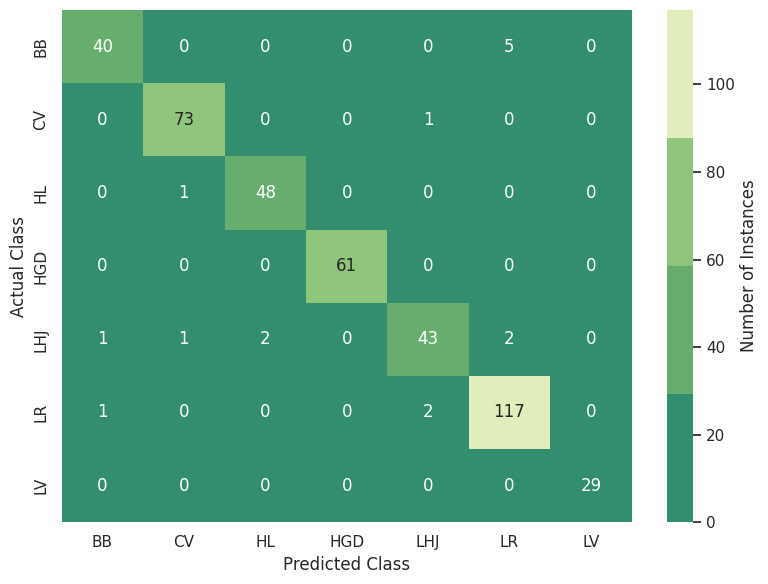

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 40,   0,   0,   0,   0,   5,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  1,   1,   2,   0,  43,   2,   0],
 [  1,   0,   0,   0,   2, 117,   0],
 [  0,   0,   0,   0,   0,   0,  29],
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

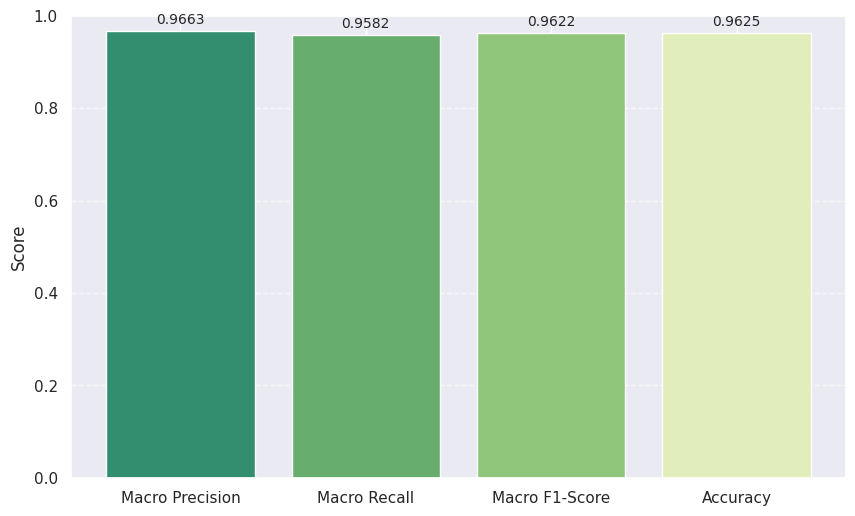

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 40,   0,   0,   0,   0,   5,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  1,   1,   2,   0,  43,   2,   0],
 [  1,   0,   0,   0,   2, 117,   0],
 [  0,   0,   0,   0,   0,   0,  29],
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZCRandFR_CI_FT40] from Confusion Matrix', fontsize=13)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40_ResNet50_evaluation_metrics[RandZCRandFR_CI].png')

# Optimal Settings (Best Performance):

Dropout 40% and Learning Rate [0.001, 0.0001]:

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.7222 - loss: 0.8146 - val_accuracy: 0.9485 - val_loss: 0.1718
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9503 - loss: 0.1407 - val_accuracy: 0.9438 - val_loss: 0.1869
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.9556 - loss: 0.1054 - val_accuracy: 0.9602 - val_loss: 0.1370
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.9774 - loss: 0.0597 - val_accuracy: 0.9461 - val_loss: 0.1998
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.9732 - loss: 0.0743 - val_accuracy: 0.9649 - val_loss: 0.1628
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9834 - loss: 0.0554 - val_accuracy: 0.9461 - val_loss: 0.1935
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.9795 - loss: 0.0510 - val_accuracy: 0.9696 - val_loss: 0.1473
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9917 - loss: 0

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 218ms/step - accuracy: 0.9497 - loss: 0.1507 - val_accuracy: 0.9438 - val_loss: 0.2095
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9713 - loss: 0.0817 - val_accuracy: 0.9696 - val_loss: 0.1196
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - accuracy: 0.9924 - loss: 0.0217 - val_accuracy: 0.9532 - val_loss: 0.1532
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.9928 - loss: 0.0204 - val_accuracy: 0.9461 - val_loss: 0.1334
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.9939 - loss: 0.0154 - val_accuracy: 0.9602 - val_loss: 0.1321
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9922 - loss: 0.0193 - val_accuracy: 0.9719 - val_loss: 0.1194
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9973 - loss: 0.0088 - val_accuracy: 0.9532 - val_loss: 0.2169
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms

In [ ]:
# Evaluate model

from sklearn.metrics import classification_report, confusion_matrix
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.9729 - loss: 0.1850
Validation loss: 0.1360, Validation accuracy: 0.9789
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.92      1.00      0.96        45
             Curl Virus       0.99      1.00      0.99        74
           Healthy Leaf       0.98      0.98      0.98        49
Herbicide Growth Damage       1.00      1.00    

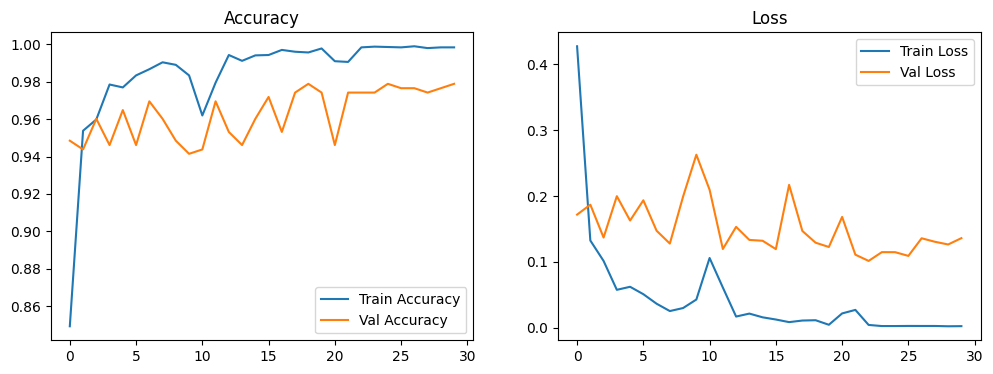

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

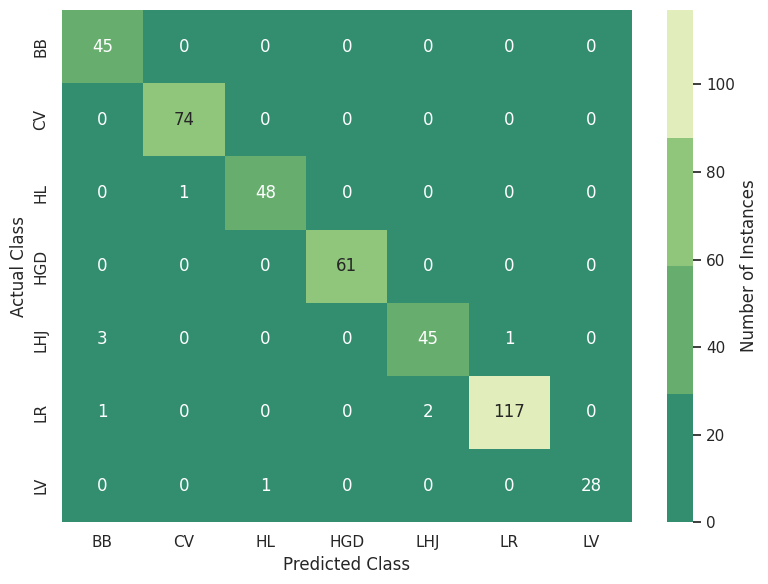

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,  0,   0,  61,   0,   0,   0],
 [  3,   0,   0,   0,  45,   1,   0],
 [  1,   0,  0,   0,   2, 117,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

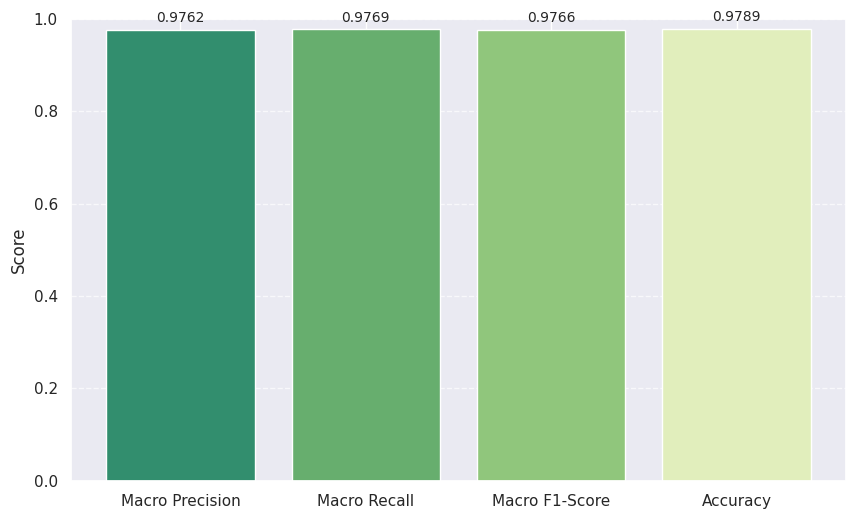

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,  0,   0,  61,   0,   0,   0],
 [  3,   0,   0,   0,  45,   1,   0],
 [  1,   0,  0,   0,   2, 117,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZCRandFR_CI_FT40] from Confusion Matrix', fontsize=13)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('FT40_ResNet50_evaluation_metrics[RandZCRandFR_CI].png')

Fine Tuning 30 Layers (Modified Dropout and LR):

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 120s 640ms/step - accuracy: 0.7407 - loss: 0.7285 - val_accuracy: 0.9391 - val_loss: 0.2113
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9388 - loss: 0.1580 - val_accuracy: 0.9368 - val_loss: 0.1785
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9560 - loss: 0.1094 - val_accuracy: 0.9485 - val_loss: 0.1706
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9719 - loss: 0.0744 - val_accuracy: 0.9415 - val_loss: 0.2434
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9706 - loss: 0.0707 - val_accuracy: 0.9555 - val_loss: 0.1436
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9820 - loss: 0.0469 - val_accuracy: 0.9649 - val_loss: 0.1244
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9854 - loss: 0.0363 - val_accuracy: 0.9578 - val_loss: 0.1571
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.9833 - loss: 

In [ ]:
# Stage 2: Fine-tune last 30 layers (exclude BatchNormalization)
for layer in base_model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 30 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 30 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 223ms/step - accuracy: 0.9613 - loss: 0.1148 - val_accuracy: 0.9578 - val_loss: 0.2059
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9802 - loss: 0.0522 - val_accuracy: 0.9625 - val_loss: 0.1389
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accuracy: 0.9578 - val_loss: 0.1490
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9893 - loss: 0.0239 - val_accuracy: 0.9602 - val_loss: 0.2040
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9965 - loss: 0.0127 - val_accuracy: 0.9696 - val_loss: 0.1058
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9924 - loss: 0.0188 - val_accuracy: 0.9578 - val_loss: 0.1179
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9940 - loss: 0.0168 - val_accuracy: 0.9485 - val_loss: 0.2303
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms

In [ ]:
# Evaluate model

from sklearn.metrics import classification_report, confusion_matrix
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9555 - loss: 0.2371
Validation loss: 0.1665, Validation accuracy: 0.9672
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.87      1.00      0.93        45
             Curl Virus       0.99      0.99      0.99        74
           Healthy Leaf       0.96      0.98      0.97        49
Herbicide Growth Damage       1.00      1.00    

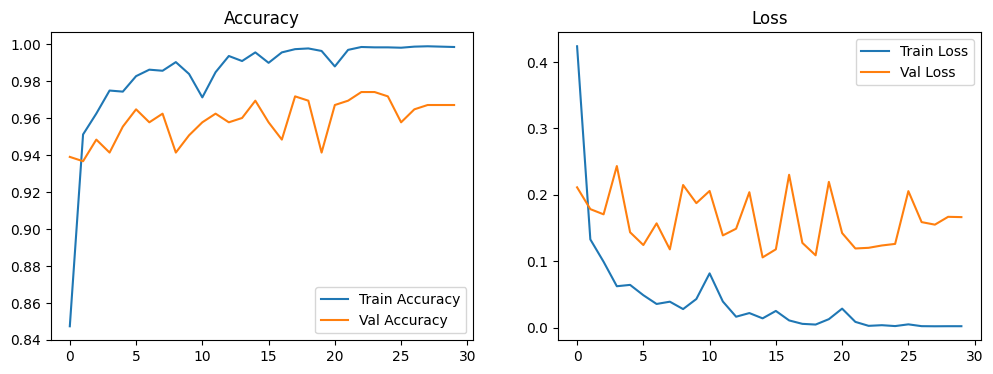

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

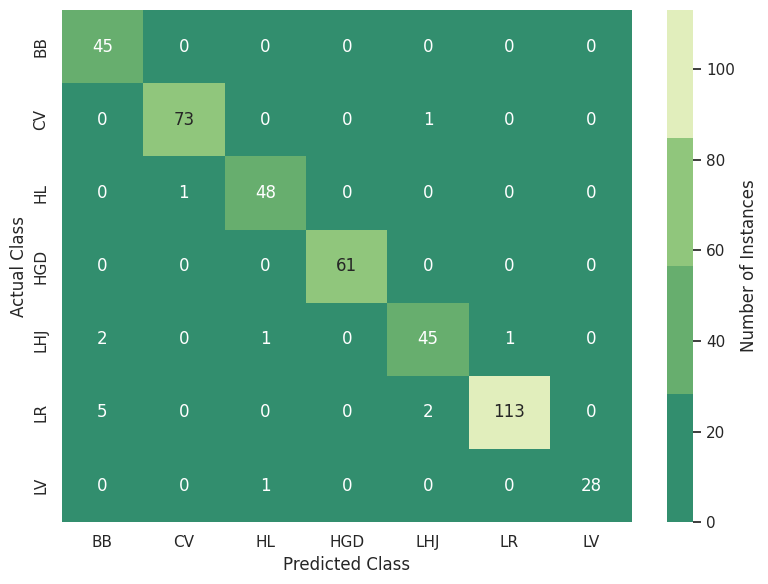

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  45,   1,   0],
 [  5,   0,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

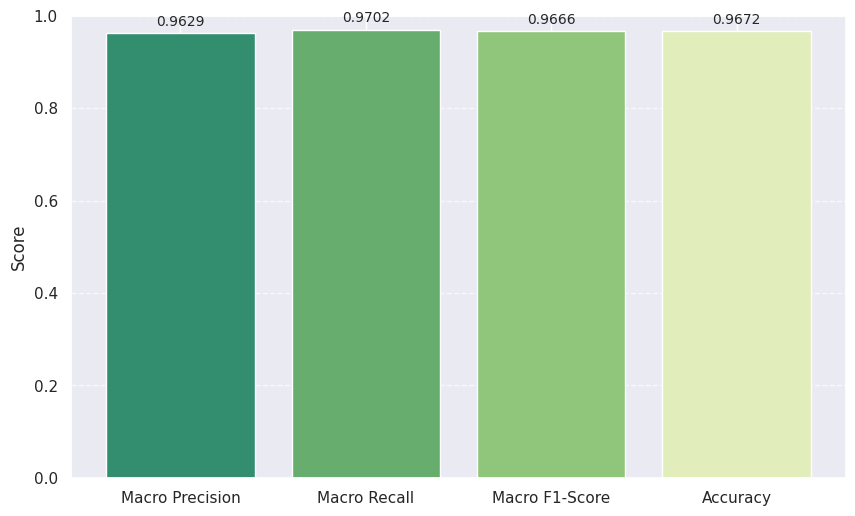

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  45,   1,   0],
 [  5,   0,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZCRandFR_CI_FT40] from Confusion Matrix', fontsize=13)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('FT40_ResNet50_evaluation_metrics[RandZCRandFR_CI].png')

# Learning Rate Scheduler Implemented:

In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler]
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.7434 - loss: 0.7427 - val_accuracy: 0.9133 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9262 - loss: 0.1752 - val_accuracy: 0.9508 - val_loss: 0.1483 - learning_rate: 0.0010
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9652 - loss: 0.0935 - val_accuracy: 0.9251 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 4/10
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9728 - loss: 0.0769
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9728 - loss: 0.0768 - val_accuracy: 0.9625 - val_loss: 0.1499 - learning_rate: 0.0010
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.9834 - loss: 0.0447 - val_accuracy: 0.9508 - val_loss: 0.1452 - learning_rate: 3.0000e-04
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler]
)

Fine-tuning the last 40 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 58s 235ms/step - accuracy: 0.9465 - loss: 0.1807 - val_accuracy: 0.9532 - val_loss: 0.1457 - learning_rate: 1.0000e-04
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9875 - loss: 0.0326 - val_accuracy: 0.9742 - val_loss: 0.1358 - learning_rate: 1.0000e-04
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9890 - loss: 0.0337 - val_accuracy: 0.9649 - val_loss: 0.1495 - learning_rate: 1.0000e-04
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9942 - loss: 0.0189 - val_accuracy: 0.9672 - val_loss: 0.1301 - learning_rate: 1.0000e-04
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 43s 166ms/step - accuracy: 0.9953 - loss: 0.0195 - val_accuracy: 0.9438 - val_loss: 0.2465 - learning_rate: 1.0000e-04
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9904 - loss: 0.0209
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
161/16

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix as sk_confusion_matrix

# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(sk_confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9654 - loss: 0.1952
Validation loss: 0.1295, Validation accuracy: 0.9742
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.88      1.00      0.94        45
             Curl Virus       0.99      0.99      0.99        74
           Healthy Leaf       0.98      0.98      0.98        49
Herbicide Growth Damage       1.00      1.00    

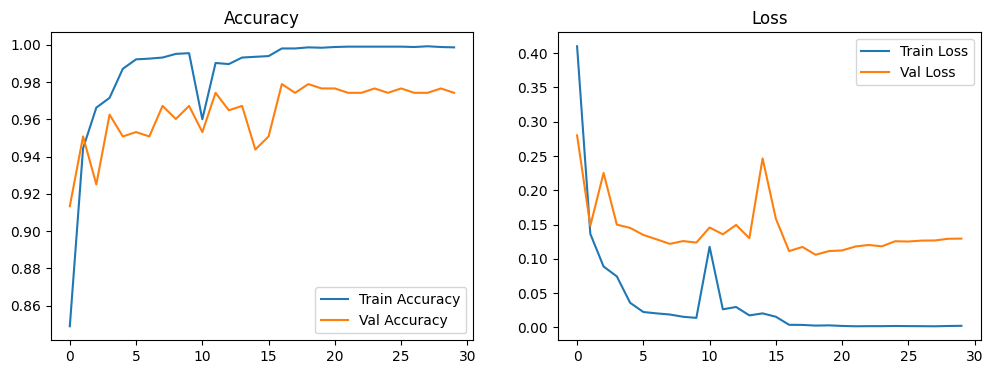

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

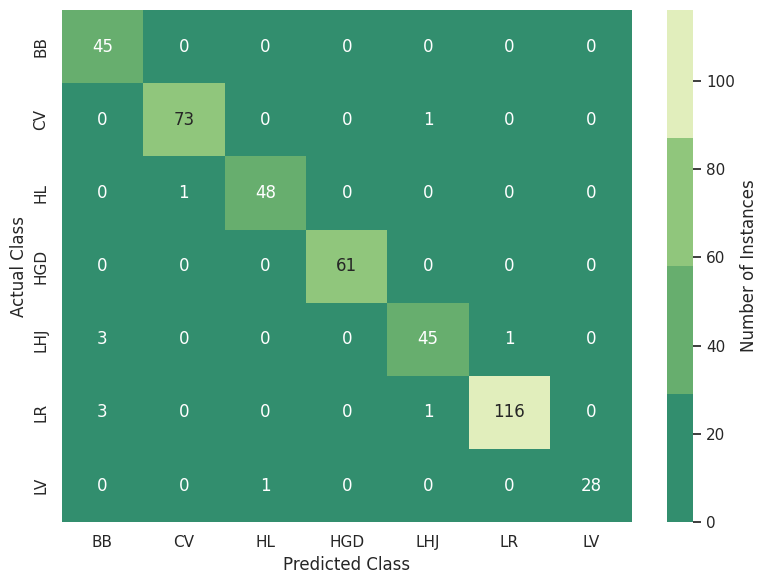

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1, 48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  3,   0,   0,   0,  45,   1,   0],
 [  3,   0,   0,   0,   1, 116,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

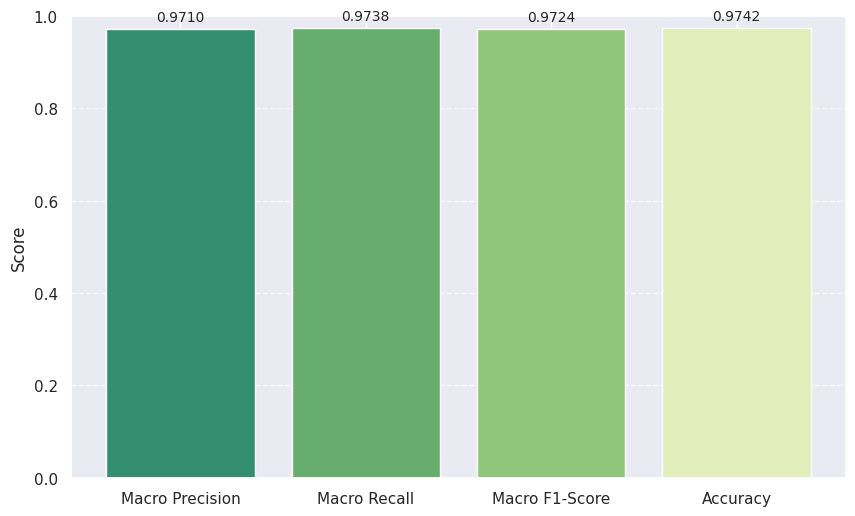

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  73,   0,   0,   1,   0,   0],
 [  0,   1, 48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  3,   0,   0,   0,  45,   1,   0],
 [  3,   0,   0,   0,   1, 116,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZCRandFR_CI_FT40] from Confusion Matrix', fontsize=13)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

# plt.savefig('FT40_ResNet50_evaluation_metrics[RandZCRandFR_CI].png')

# Comparison with Inception V3 [Bishshash]:

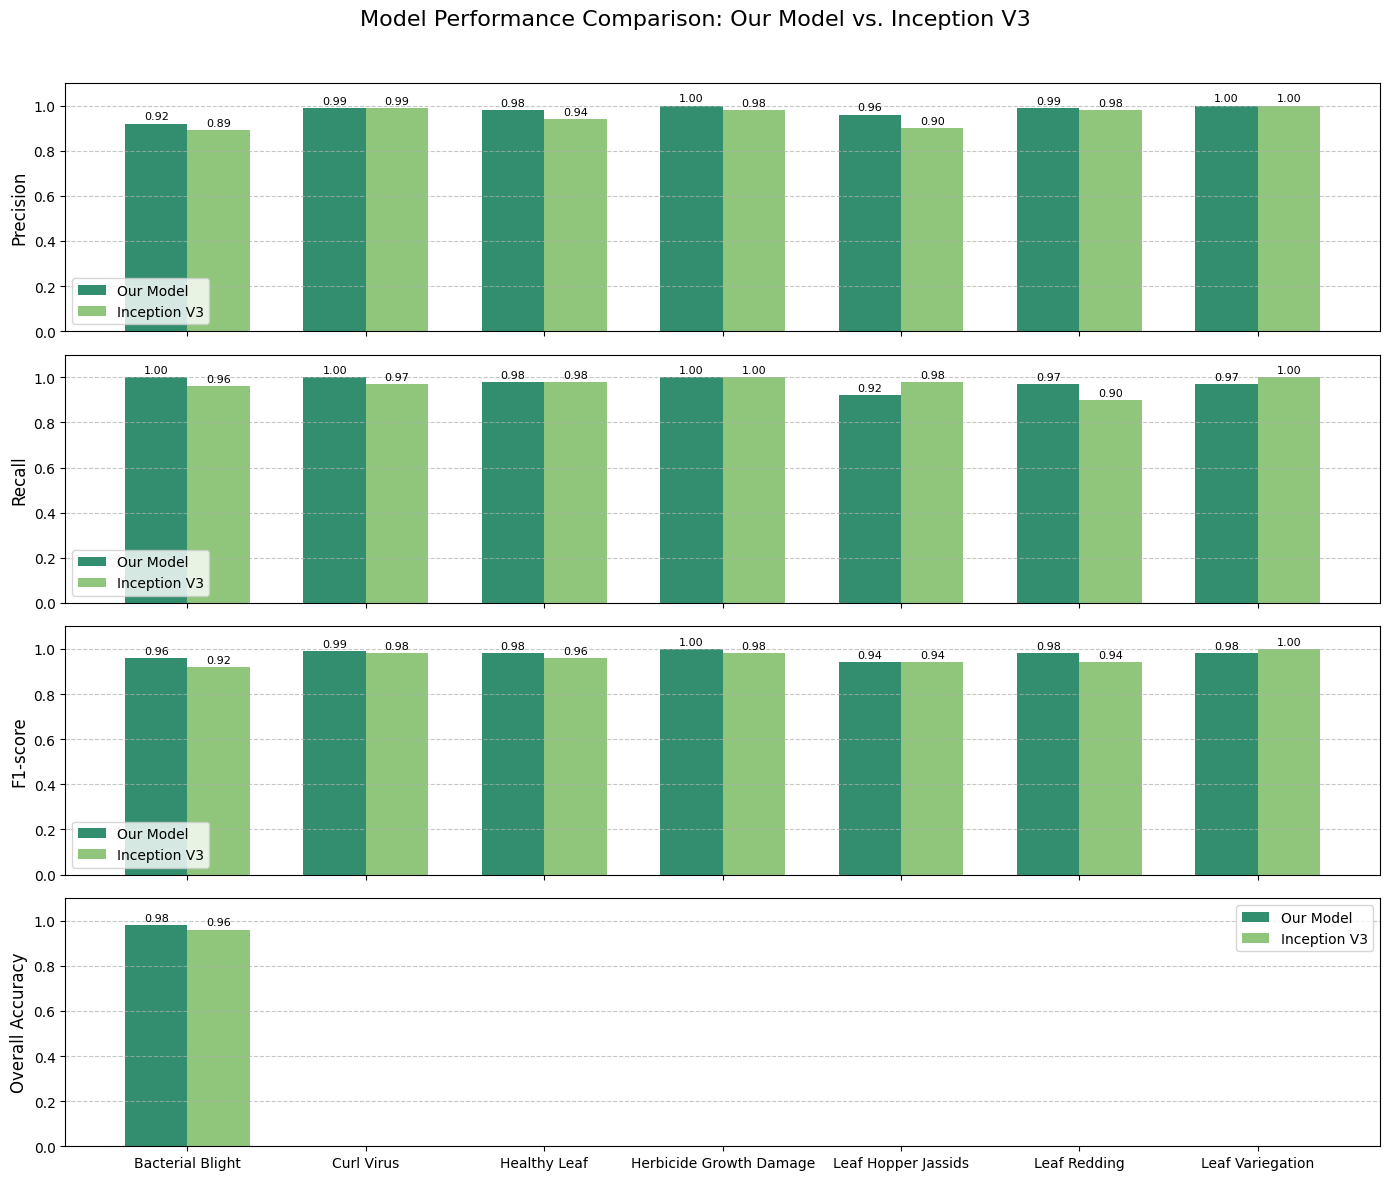

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your model
your_model_metrics = {
    'Bacterial Blight': {'precision': 0.92, 'recall': 1.00, 'f1-score': 0.96},
    'Curl Virus': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99},
    'Healthy Leaf': {'precision': 0.98, 'recall': 0.98, 'f1-score': 0.98},
    'Herbicide Growth Damage': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00},
    'Leaf Hopper Jassids': {'precision': 0.96, 'recall': 0.92, 'f1-score': 0.94},
    'Leaf Redding': {'precision': 0.99, 'recall': 0.97, 'f1-score': 0.98},
    'Leaf Variegation': {'precision': 1.00, 'recall': 0.97, 'f1-score': 0.98},
    'Overall Accuracy': 0.9789
}

# Data from related paper (Inception V3)
paper_metrics = {
    'Bacterial Blight': {'precision': 0.89, 'recall': 0.96, 'f1-score': 0.92},
    'Curl Virus': {'precision': 0.99, 'recall': 0.97, 'f1-score': 0.98},
    'Healthy Leaf': {'precision': 0.94, 'recall': 0.98, 'f1-score': 0.96},
    'Herbicide Growth Damage': {'precision': 0.98, 'recall': 1.00, 'f1-score': 0.98},
    'Leaf Hopper Jassids': {'precision': 0.90, 'recall': 0.98, 'f1-score': 0.94},
    'Leaf Redding': {'precision': 0.98, 'recall': 0.90, 'f1-score': 0.94},
    'Leaf Variegation': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00},
    'Overall Accuracy': 0.9603
}

# Class names and metrics to compare
class_names = ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
               'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']
metrics = ['precision', 'recall', 'f1-score']

# Set up the plot
fig, axes = plt.subplots(len(metrics) + 1, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Model Performance Comparison: Our Model vs. Inception V3', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    your_values = [your_model_metrics[class_name][metric] for class_name in class_names]
    paper_values = [paper_metrics[class_name][metric] for class_name in class_names]

    x = np.arange(len(class_names))
    width = 0.35

    axes[i].bar(x - width/2, your_values, width, label='Our Model', color='#328E6E')
    axes[i].bar(x + width/2, paper_values, width, label='Inception V3', color='#90C67C')

    axes[i].set_ylabel(metric.capitalize(), fontsize=12)
    axes[i].set_ylim(0, 1.1)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].legend()

    # Add value labels on top of bars
    for j, (yv, pv) in enumerate(zip(your_values, paper_values)):
        axes[i].text(j - width/2, yv + 0.01, f'{yv:.2f}', ha='center', va='bottom', fontsize=8)
        axes[i].text(j + width/2, pv + 0.01, f'{pv:.2f}', ha='center', va='bottom', fontsize=8)

# Plot overall accuracy
x = np.arange(1)
width = 0.35
axes[-1].bar(x - width/2, [your_model_metrics['Overall Accuracy']], width, label='Our Model', color='#328E6E')
axes[-1].bar(x + width/2, [paper_metrics['Overall Accuracy']], width, label='Inception V3', color='#90C67C')
axes[-1].set_ylabel('Overall Accuracy', fontsize=12)
axes[-1].set_ylim(0, 1.1)
axes[-1].grid(axis='y', linestyle='--', alpha=0.7)
axes[-1].legend()
axes[-1].set_xticks([])

# Add value labels for accuracy
axes[-1].text(0 - width/2, your_model_metrics['Overall Accuracy'] + 0.01, f'{your_model_metrics["Overall Accuracy"]:.2f}',
              ha='center', va='bottom', fontsize=8)
axes[-1].text(0 + width/2, paper_metrics['Overall Accuracy'] + 0.01, f'{paper_metrics["Overall Accuracy"]:.2f}',
              ha='center', va='bottom', fontsize=8)

# Set x-axis labels for class names (only on the last subplot)
axes[-2].set_xticks(np.arange(len(class_names)))
axes[-2].set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('model_comparison_plot.png')
plt.show()

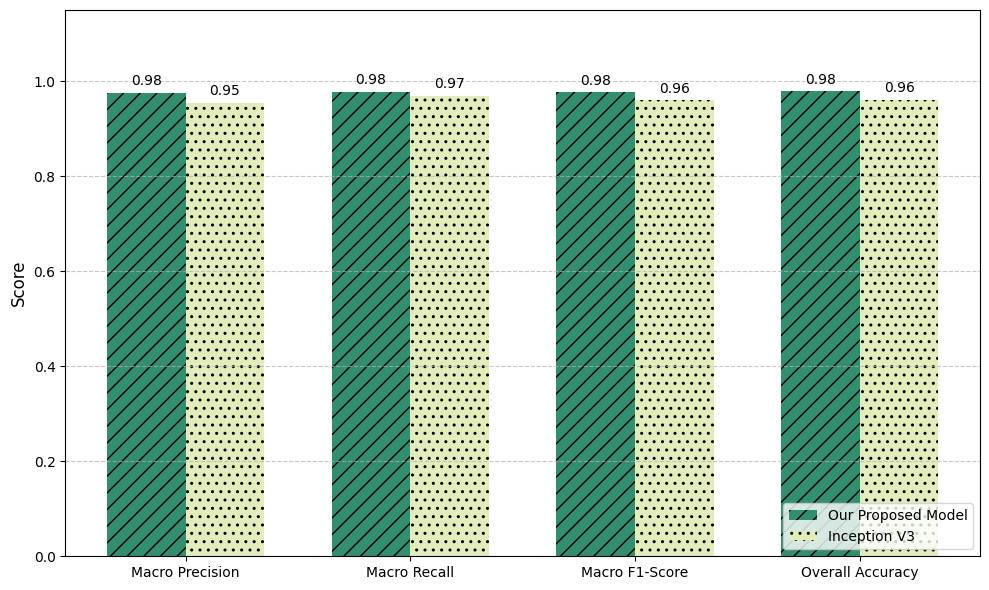

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your model (macro-average and overall accuracy)
your_model_metrics = {
    'Macro Precision': 0.9762,
    'Macro Recall': 0.9769,
    'Macro F1-Score': 0.9766,
    'Overall Accuracy': 0.9789
}

# Data from related paper (Inception V3)
paper_metrics = {
    'Macro Precision': (0.89 + 0.99 + 0.94 + 0.98 + 0.90 + 0.98 + 1.00) / 7.0,
    'Macro Recall': (0.96 + 0.97 + 0.98 + 1.00 + 0.98 + 0.90 + 1.00) / 7.0,
    'Macro F1-Score': (0.92 + 0.98 + 0.96 + 0.98 + 0.94 + 0.94 + 1.00) / 7.0,
    'Overall Accuracy': 0.9603
}

# Metrics to compare
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Overall Accuracy']

# Set up the plot
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

# Plot bars with new colors and hatch patterns
plt.bar(x - width/2, [your_model_metrics[m] for m in metrics], width,
        label='Our Proposed Model', color='#328E6E', hatch='//')
plt.bar(x + width/2, [paper_metrics[m] for m in metrics], width,
        label='Inception V3', color='#E1EEBC', hatch='..')

# Add value labels on top of bars
for i, m in enumerate(metrics):
    plt.text(i - width/2, your_model_metrics[m] + 0.01, f'{your_model_metrics[m]:.2f}',
             ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, paper_metrics[m] + 0.01, f'{paper_metrics[m]:.2f}',
             ha='center', va='bottom', fontsize=10)

# Customize plot
plt.ylabel('Score', fontsize=12)
plt.xticks(x, metrics, fontsize=10)
plt.ylim(0, 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Adjust layout and save
plt.tight_layout()
plt.savefig('overall_metrics_comparison.png')
plt.show()